Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [189]:
# imports
import requests
import os
import pandas as pd
import json  
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import numpy as np

In [84]:
# Join Data
bike_stations_toronto = pd.read_csv(r'C:\Users\akans\Documents\Kierans_Documents\LHL\Statistical-Modelling-Project\data\bike_stations_toronto.csv')
results_four = pd.read_csv(r'C:\Users\akans\Documents\Kierans_Documents\LHL\Statistical-Modelling-Project\data\results_four.csv')
results_yelp = pd.read_csv(r'C:\Users\akans\Documents\Kierans_Documents\LHL\Statistical-Modelling-Project\data\results_yelp.csv')
bike_stations_toronto = pd.DataFrame(bike_stations_toronto)
results_four = pd.DataFrame(results_four)
results_yelp = pd.DataFrame(results_yelp)

# Based on the previous choice made in yelp_foursquare_EDA.ipynb, I will only join the yelp data to the citybikes data
bike_stations_and_places_temp = pd.merge(bike_stations_toronto, results_yelp, on=['latitude', 'longitude'], how='inner')

In [85]:
# Drop all qualitative values, and because of the limit on Yelp API requests, I have no need to further filter by query ('restaurant','bar','art') 
# as the data is only from the yelp request "restaurant"
# For modelling a linear regression, only the quantitative values are kept, where my "y" of the formula y = mx + b will be "free_bikes"
bs_quant_df = bike_stations_and_places_temp.drop(columns=['longitude', 'latitude', 'Unnamed: 0', 'name', 'api', 'query'])

# As total is a count relative to longitude and latitude like free_bikes is, filter so that there is one total and free_bikes value per bike station
bs_total_df = bike_stations_and_places_temp.drop_duplicates(subset=['longitude', 'latitude'])
bs_total_df = bs_total_df.drop(columns=['rating','review_count','distance','longitude', 'latitude', 'Unnamed: 0', 'name', 'api', 'query'])



Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

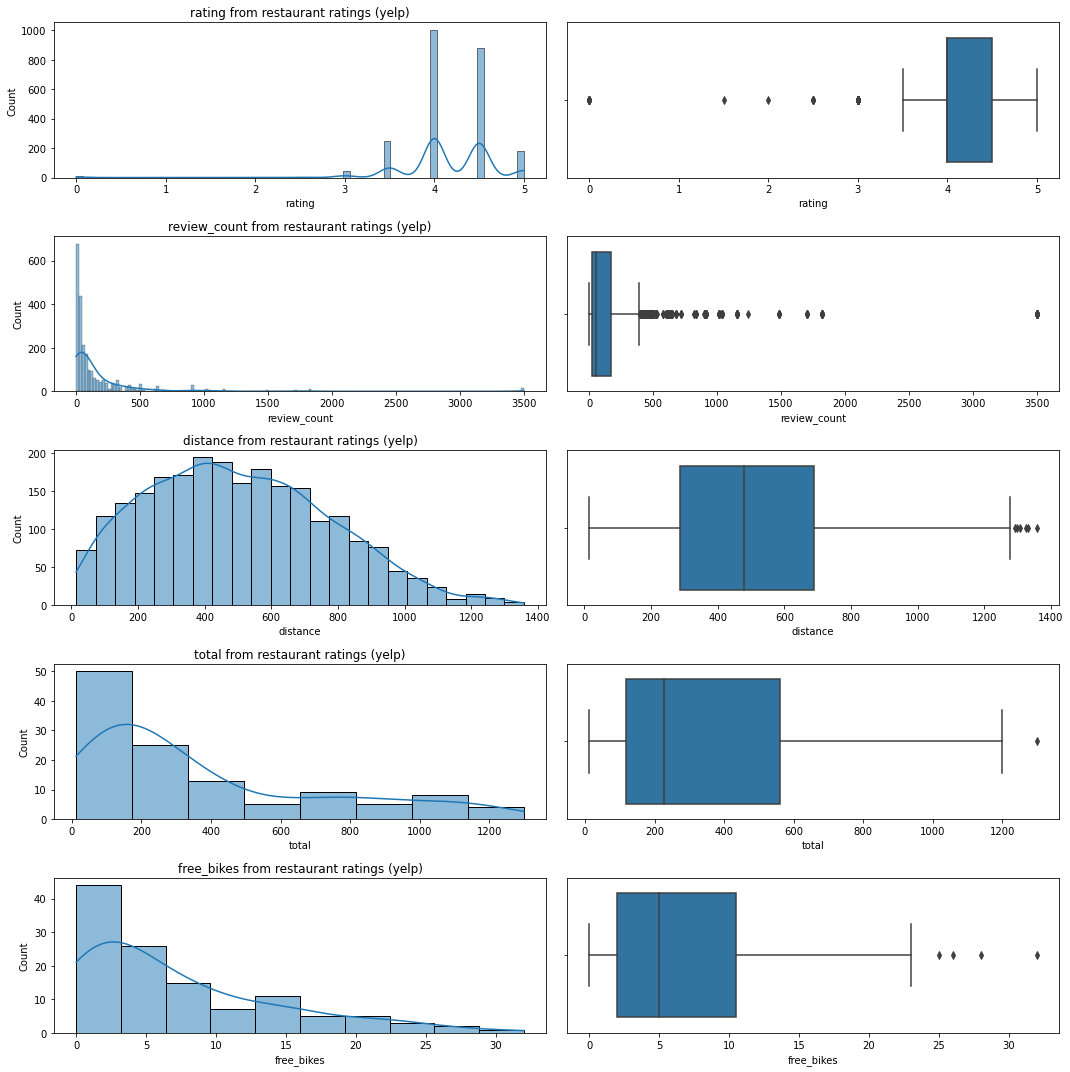

In [165]:
# Histograms and Boxplots of each variable

# Set Plot Dimensions
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# Plot rating
sns.histplot    (x=bs_quant_df['rating'], ax=axes[0][0], kde=True)
rating_boxplot = sns.boxplot(x=bs_quant_df['rating'], ax=axes[0][1], orient='y')
axes[0][0].set_title('rating from restaurant ratings (yelp)', loc='center')

# Plot review_count
sns.histplot    (x=bs_quant_df['review_count'], ax=axes[1][0], kde=True)
review_count_boxplot = sns.boxplot(x=bs_quant_df['review_count'], ax=axes[1][1], orient='y')
axes[1][0].set_title('review_count from restaurant ratings (yelp)', loc='center')



# Plot distance
sns.histplot    (x=bs_quant_df['distance'], ax=axes[2][0], kde=True)
distance_boxplot = sns.boxplot(x=bs_quant_df['distance'], ax=axes[2][1], orient='y')
axes[2][0].set_title('distance from restaurant ratings (yelp)', loc='center')


# Plot total
sns.histplot    (x=bs_total_df['total'], ax=axes[3][0], kde=True)
total_boxplot = sns.boxplot    (x=bs_total_df['total'], ax=axes[3][1], orient='y')
axes[3][0].set_title('total from restaurant ratings (yelp)', loc='center')


# Plot free_bikes
sns.histplot    (x=bs_total_df['free_bikes'], ax=axes[4][0], kde=True)
free_bikes_boxplot = sns.boxplot    (x=bs_total_df['free_bikes'], ax=axes[4][1], orient='y')
axes[4][0].set_title('free_bikes from restaurant ratings (yelp)', loc='center')

# Plot Histogram 
plt.tight_layout()
plt.show()

The histograms show that most of the data is skewed, with the exceptions of distance and rating, which show a more normal distribution.  
The boxplots show many outliers in the data, which will be removed subsequently.

In [156]:
# Stage clean dataframes of the data
bs_quant_clean_df = bs_quant_df
bs_total_clean_df = bs_total_df

def outliers_full (column_name): 
    """
    Function to remove outliers based on rating, review_count, and distance
    """
    global bs_quant_clean_df

    # Establish Outlier Measurements
    Q1 = bs_quant_df[column_name].quantile(0.25)
    Q3 = bs_quant_df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove Outliers from Clean Dataframe
    bs_quant_clean_df = bs_quant_clean_df[(bs_quant_clean_df[column_name] >= lower_bound) & (bs_quant_clean_df[column_name] <= upper_bound)]

    # Print the number of outliers removed
    num_outliers_removed =  len(bs_quant_df) - len(bs_quant_df[(bs_quant_df[column_name] >= lower_bound) & (bs_quant_df[column_name] <= upper_bound)])
    print(f"{num_outliers_removed} outliers of {len(bs_quant_df)} records removed from the {column_name} column")


def outliers_total (column_name): 
    """
    Function to remove outliers based on free_bikes and total
    """
    global bs_total_clean_df
    global bs_quant_clean_df

    # Establish Outlier Measurements
    Q1 = bs_total_df[column_name].quantile(0.25)
    Q3 = bs_total_df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove Outliers from Clean Dataframes
    bs_quant_clean_df = bs_quant_clean_df[(bs_quant_clean_df[column_name] >= lower_bound) & (bs_quant_clean_df[column_name] <= upper_bound)]
    bs_total_clean_df = bs_total_clean_df[(bs_total_clean_df[column_name] >= lower_bound) & (bs_total_clean_df[column_name] <= upper_bound)]

    # Print the number of outliers removed from the quant dataframe
    num_outliers_removed_quant =  len(bs_quant_df) - len(bs_quant_df[(bs_quant_df[column_name] >= lower_bound) & (bs_quant_df[column_name] <= upper_bound)])
    print(f"{num_outliers_removed_quant} outliers of {len(bs_quant_df)} records removed from the {column_name} column in the quant DataFrame")

    # Print the number of outliers removed from the total dataframe
    num_outliers_removed_total =  len(bs_total_df) - len(bs_total_df[(bs_total_df[column_name] >= lower_bound) & (bs_total_df[column_name] <= upper_bound)])
    print(f"{num_outliers_removed_total} outliers of {len(bs_total_df)} records removed from the {column_name} column in the total DataFrame")



In [157]:
# Run the outlier removal functions
outliers_full('review_count')
outliers_full('distance')
outliers_full('rating')
outliers_total('total')
outliers_total('free_bikes')

263 outliers of 2372 records removed from the review_count column
6 outliers of 2372 records removed from the distance column
65 outliers of 2372 records removed from the rating column
20 outliers of 2372 records removed from the total column in the quant DataFrame
1 outliers of 119 records removed from the total column in the total DataFrame
80 outliers of 2372 records removed from the free_bikes column in the quant DataFrame
4 outliers of 119 records removed from the free_bikes column in the total DataFrame


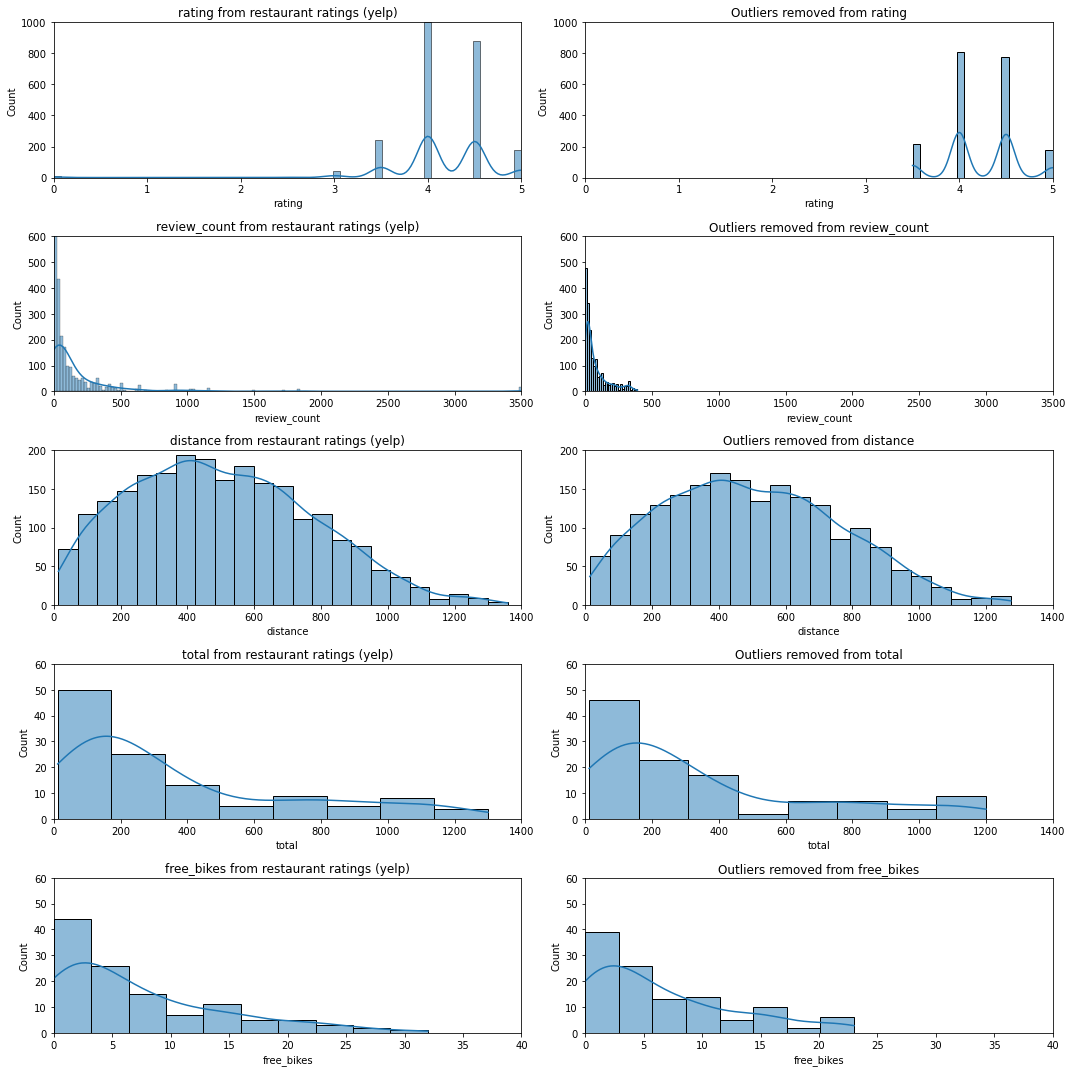

In [166]:
# Histograms and Boxplots of each variable

# Set Plot Dimensions
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# Plot rating
sns.histplot    (x=bs_quant_df['rating'], ax=axes[0][0], kde=True)
sns.histplot    (x=bs_quant_clean_df['rating'], ax=axes[0][1], kde=True)
axes[0][0].set_title('rating from restaurant ratings (yelp)', loc='center')
axes[0][1].set_title('Outliers removed from rating', loc='center')
axes[0][0].set_xlim(0,5)
axes[0][0].set_ylim(0,1000)
axes[0][1].set_xlim(0,5)
axes[0][1].set_ylim(0,1000)

# Plot review_count
sns.histplot    (x=bs_quant_df['review_count'], ax=axes[1][0], kde=True)
sns.histplot    (x=bs_quant_clean_df['review_count'], ax=axes[1][1], kde=True)
axes[1][0].set_title('review_count from restaurant ratings (yelp)', loc='center')
axes[1][1].set_title('Outliers removed from review_count', loc='center')
axes[1][0].set_xlim(0,3500)
axes[1][0].set_ylim(0,600)
axes[1][1].set_xlim(0,3500)
axes[1][1].set_ylim(0,600)


# Plot distance
sns.histplot    (x=bs_quant_df['distance'], ax=axes[2][0], kde=True)
sns.histplot    (x=bs_quant_clean_df['distance'], ax=axes[2][1], kde=True)
axes[2][0].set_title('distance from restaurant ratings (yelp)', loc='center')
axes[2][1].set_title('Outliers removed from distance', loc='center')
axes[2][0].set_xlim(0,1400)
axes[2][0].set_ylim(0,200)
axes[2][1].set_xlim(0,1400)
axes[2][1].set_ylim(0,200)


# Plot total
sns.histplot    (x=bs_total_df['total'], ax=axes[3][0], kde=True)
sns.histplot    (x=bs_total_clean_df['total'], ax=axes[3][1], kde=True)
axes[3][0].set_title('total from restaurant ratings (yelp)', loc='center')
axes[3][1].set_title('Outliers removed from total', loc='center')
axes[3][0].set_xlim(0,1400)
axes[3][0].set_ylim(0,60)
axes[3][1].set_xlim(0,1400)
axes[3][1].set_ylim(0,60)


# Plot free_bikes
sns.histplot    (x=bs_total_df['free_bikes'], ax=axes[4][0], kde=True)
sns.histplot    (x=bs_total_clean_df['free_bikes'], ax=axes[4][1], kde=True)
axes[4][0].set_title('free_bikes from restaurant ratings (yelp)', loc='center')
axes[4][1].set_title('Outliers removed from free_bikes', loc='center')
axes[4][0].set_xlim(0,40)
axes[4][0].set_ylim(0,60)
axes[4][1].set_xlim(0,40)
axes[4][1].set_ylim(0,60)

# Plot Histogram 
plt.tight_layout()
plt.show()

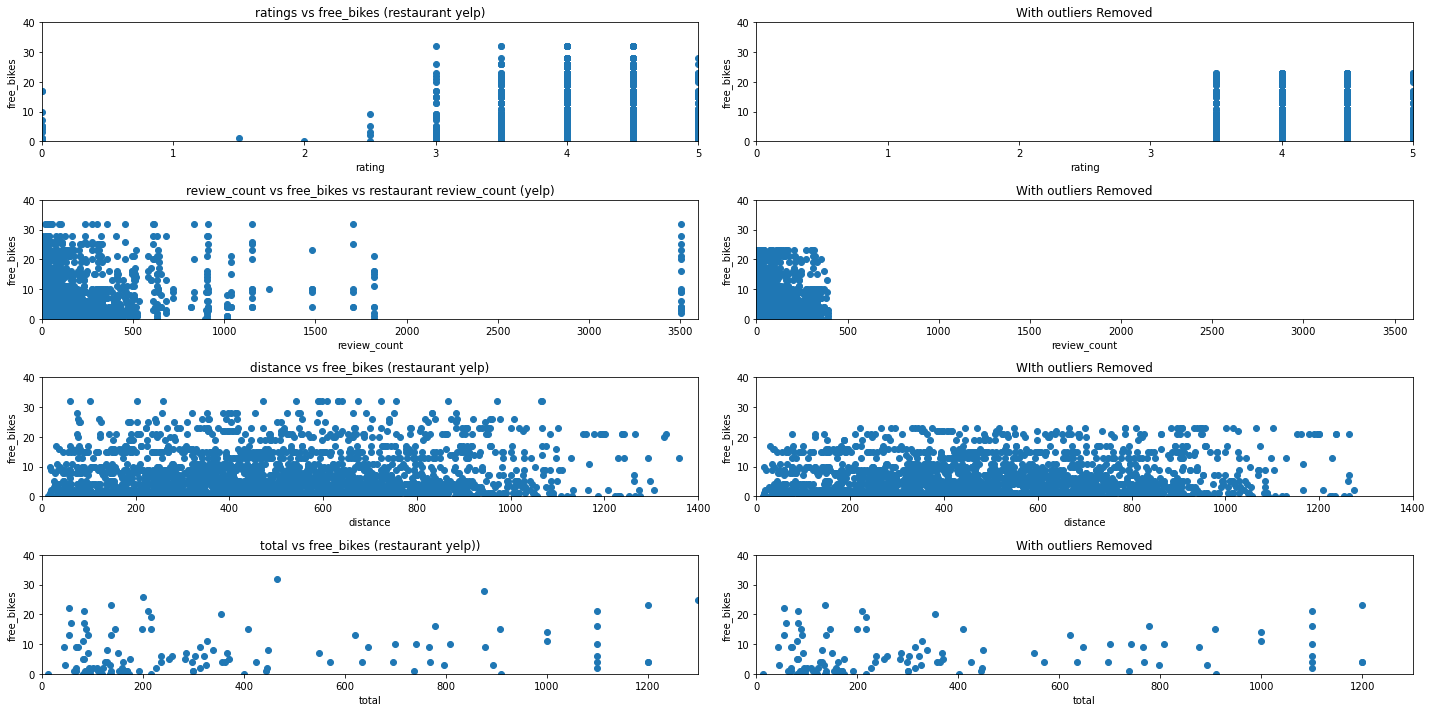

In [177]:
# Scatterplots showing the relationship of the Y variable "free_bikes" to each of the X variables

# Set Plot Dimensions
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))

# Plot rating
axes[0][0].scatter(bs_quant_df['rating'], bs_quant_df['free_bikes'])
axes[0][0].set_xlabel('rating')
axes[0][0].set_ylabel('free_bikes')
axes[0][0].set_title('ratings vs free_bikes (restaurant yelp)')
axes[0][0].set_xlim(0,5)
axes[0][0].set_ylim(0,40)

axes[0][1].scatter(bs_quant_clean_df['rating'], bs_quant_clean_df['free_bikes'])
axes[0][1].set_xlabel('rating')
axes[0][1].set_ylabel('free_bikes')
axes[0][1].set_title('With outliers Removed')
axes[0][1].set_xlim(0,5)
axes[0][1].set_ylim(0,40)


# Plot review_count
axes[1][0].scatter(bs_quant_df['review_count'], bs_quant_df['free_bikes'])
axes[1][0].set_xlabel('review_count')
axes[1][0].set_ylabel('free_bikes')
axes[1][0].set_title('review_count vs free_bikes vs restaurant review_count (yelp)')
axes[1][0].set_xlim(0,3600)
axes[1][0].set_ylim(0,40)

axes[1][1].scatter(bs_quant_clean_df['review_count'], bs_quant_clean_df['free_bikes'])
axes[1][1].set_xlabel('review_count')
axes[1][1].set_ylabel('free_bikes')
axes[1][1].set_title('With outliers Removed')
axes[1][1].set_xlim(0,3600)
axes[1][1].set_ylim(0,40)

# Plot distance
axes[2][0].scatter(bs_quant_df['distance'], bs_quant_df['free_bikes'])
axes[2][0].set_xlabel('distance')
axes[2][0].set_ylabel('free_bikes')
axes[2][0].set_title('distance vs free_bikes (restaurant yelp)')
axes[2][0].set_xlim(0,1400)
axes[2][0].set_ylim(0,40)

axes[2][1].scatter(bs_quant_clean_df['distance'], bs_quant_clean_df['free_bikes'])
axes[2][1].set_xlabel('distance')
axes[2][1].set_ylabel('free_bikes')
axes[2][1].set_title('WIth outliers Removed')
axes[2][1].set_xlim(0,1400)
axes[2][1].set_ylim(0,40)

# Plot total
axes[3][0].scatter(bs_total_df['total'], bs_total_df['free_bikes'])
axes[3][0].set_xlabel('total')
axes[3][0].set_ylabel('free_bikes')
axes[3][0].set_title('total vs free_bikes (restaurant yelp))')
axes[3][0].set_xlim(0,1300)
axes[3][0].set_ylim(0,40)

axes[3][1].scatter(bs_total_clean_df['total'], bs_total_clean_df['free_bikes'])
axes[3][1].set_xlabel('total')
axes[3][1].set_ylabel('free_bikes')
axes[3][1].set_title('With outliers Removed')
axes[3][1].set_xlim(0,1300)
axes[3][1].set_ylim(0,40)

# Scatterplots
plt.tight_layout()
plt.show()


C:\Users\akans\AppData\Local\Temp\ipykernel_23336\2627357878.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_quant_log_df['rating_log'] = np.log(bs_quant_log_df['rating'])
C:\Users\akans\AppData\Local\Temp\ipykernel_23336\2627357878.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_quant_log_df['distance_log'] = np.log(bs_quant_log_df['distance'])
C:\Users\akans\AppData\Local\Temp\ipykernel_23336\2627357878.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

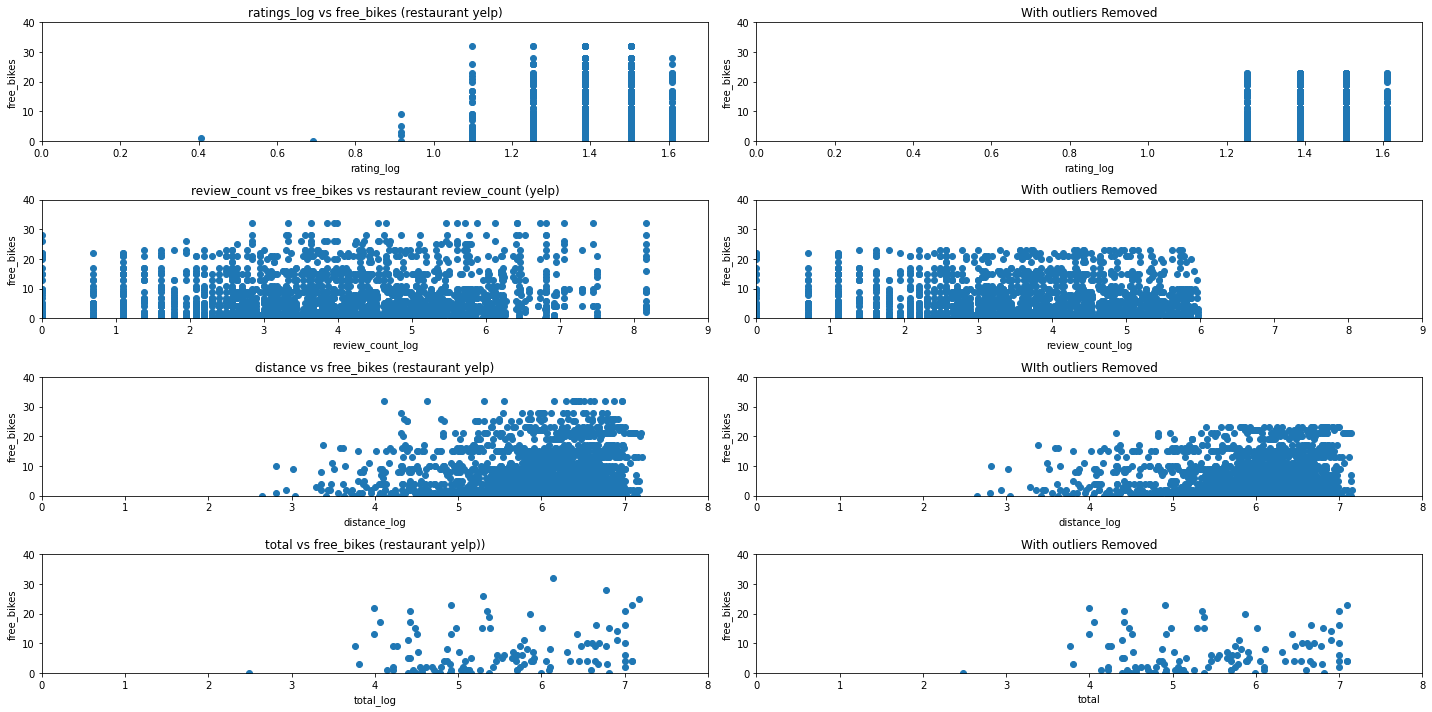

In [195]:
# Transforming the X Data by log
bs_quant_log_df = bs_quant_df
bs_quant_log_clean_df = bs_quant_clean_df
bs_total_log_clean_df = bs_total_clean_df
bs_total_log_df = bs_total_df

# Clean data for log transformation
bs_quant_log_df = bs_quant_log_df[bs_quant_log_df['review_count'] > 0]
bs_quant_log_clean_df = bs_quant_log_clean_df[bs_quant_log_clean_df['review_count'] > 0]

# Transform the data
bs_quant_log_df['rating_log'] = np.log(bs_quant_log_df['rating'])
bs_quant_log_clean_df['rating_log'] = np.log(bs_quant_log_clean_df['rating'])
bs_quant_log_df['distance_log'] = np.log(bs_quant_log_df['distance'])
bs_quant_log_clean_df['distance_log'] = np.log(bs_quant_log_clean_df['distance'])
bs_quant_log_df['review_count_log'] = np.log(bs_quant_log_df['review_count'])
bs_quant_log_clean_df['review_count_log'] = np.log(bs_quant_log_clean_df['review_count'])
bs_total_log_df['total_log'] = np.log(bs_total_log_df['total'])
bs_total_log_clean_df['total_log']= np.log(bs_total_log_clean_df['total'])

# Plot the Transformation

# Set Plot Dimensions
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))

# Plot rating
axes[0][0].scatter(bs_quant_log_df['rating_log'], bs_quant_log_df['free_bikes'])
axes[0][0].set_xlabel('rating_log')
axes[0][0].set_ylabel('free_bikes')
axes[0][0].set_title('ratings_log vs free_bikes (restaurant yelp)')
axes[0][0].set_xlim(0,1.7)
axes[0][0].set_ylim(0,40)

axes[0][1].scatter(bs_quant_log_clean_df['rating_log'], bs_quant_log_clean_df['free_bikes'])
axes[0][1].set_xlabel('rating_log')
axes[0][1].set_ylabel('free_bikes')
axes[0][1].set_title('With outliers Removed')
axes[0][1].set_xlim(0,1.7)
axes[0][1].set_ylim(0,40)


# Plot review_count
axes[1][0].scatter(bs_quant_log_df['review_count_log'], bs_quant_log_df['free_bikes'])
axes[1][0].set_xlabel('review_count_log')
axes[1][0].set_ylabel('free_bikes')
axes[1][0].set_title('review_count_log vs free_bikes vs restaurant review_count (yelp)')
axes[1][0].set_xlim(0,9)
axes[1][0].set_ylim(0,40)

axes[1][1].scatter(bs_quant_log_clean_df['review_count_log'], bs_quant_log_clean_df['free_bikes'])
axes[1][1].set_xlabel('review_count_log')
axes[1][1].set_ylabel('free_bikes')
axes[1][1].set_title('With outliers Removed')
axes[1][1].set_xlim(0,9)
axes[1][1].set_ylim(0,40)

# Plot distance
axes[2][0].scatter(bs_quant_log_df['distance_log'], bs_quant_log_df['free_bikes'])
axes[2][0].set_xlabel('distance_log')
axes[2][0].set_ylabel('free_bikes')
axes[2][0].set_title('distance_log vs free_bikes (restaurant yelp)')
axes[2][0].set_xlim(0,8)
axes[2][0].set_ylim(0,40)

axes[2][1].scatter(bs_quant_log_clean_df['distance_log'], bs_quant_log_clean_df['free_bikes'])
axes[2][1].set_xlabel('distance_log')
axes[2][1].set_ylabel('free_bikes')
axes[2][1].set_title('WIth outliers Removed')
axes[2][1].set_xlim(0,8)
axes[2][1].set_ylim(0,40)

# Plot total
axes[3][0].scatter(bs_total_log_df['total_log'], bs_total_log_df['free_bikes'])
axes[3][0].set_xlabel('total_log')
axes[3][0].set_ylabel('free_bikes')
axes[3][0].set_title('total_log vs free_bikes (restaurant yelp))')
axes[3][0].set_xlim(0,8)
axes[3][0].set_ylim(0,40)

axes[3][1].scatter(bs_total_log_clean_df['total_log'], bs_total_log_clean_df['free_bikes'])
axes[3][1].set_xlabel('total_log')
axes[3][1].set_ylabel('free_bikes')
axes[3][1].set_title('With outliers Removed')
axes[3][1].set_xlim(0,8)
axes[3][1].set_ylim(0,40)

# Scatterplots
plt.tight_layout()
plt.show()

C:\Users\akans\AppData\Local\Temp\ipykernel_23336\1113136301.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_total_log_df['total_log'] = np.log(bs_total_log_df['total'])
C:\Users\akans\AppData\Local\Temp\ipykernel_23336\1113136301.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_total_log_clean_df['total_log']= np.log(bs_total_log_clean_df['total'])
C:\Users\akans\AppData\Local\Temp\ipykernel_23336\1113136301.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

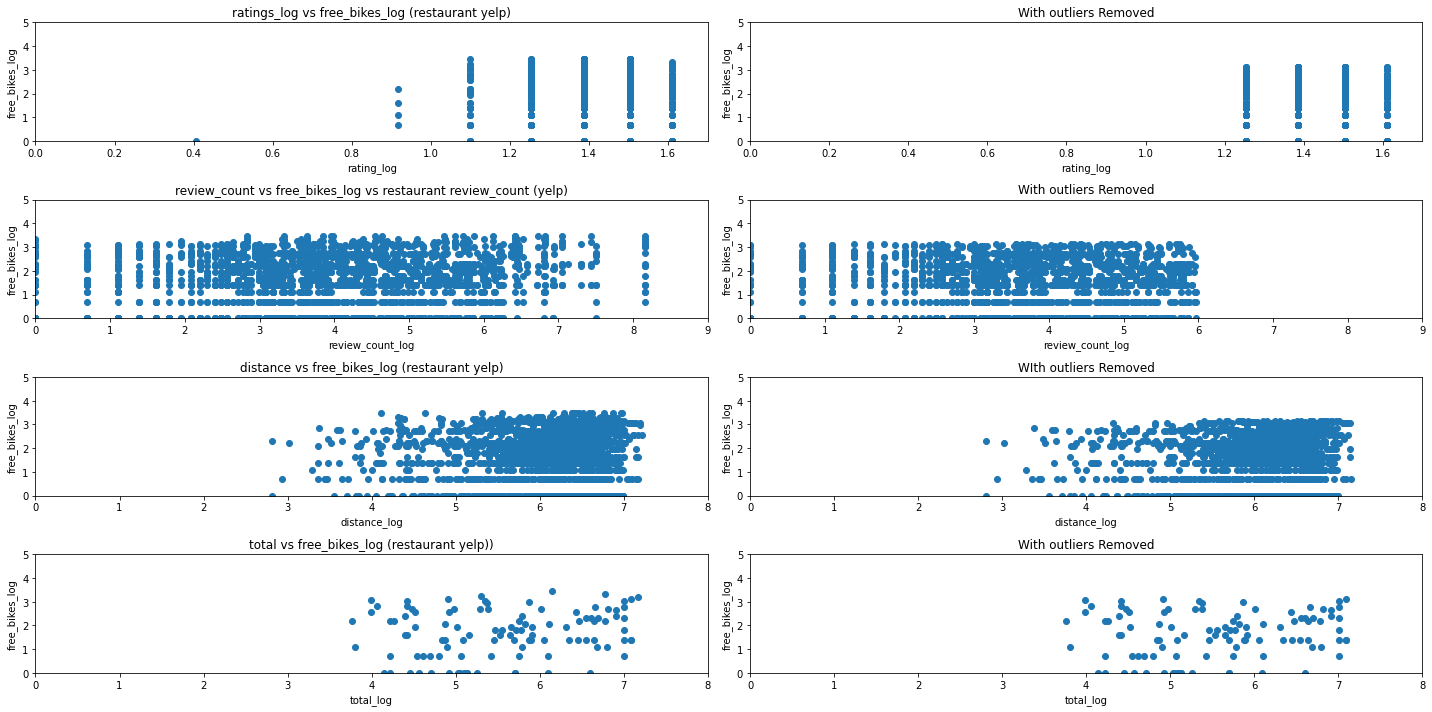

In [199]:
# Transforming the X and Y Data by log
bs_quant_log_df = bs_quant_df
bs_quant_log_clean_df = bs_quant_clean_df
bs_total_log_clean_df = bs_total_clean_df
bs_total_log_df = bs_total_df

# Clean data for log transformation
bs_quant_log_df = bs_quant_log_df[bs_quant_log_df['review_count'] > 0]
bs_quant_log_clean_df = bs_quant_log_clean_df[bs_quant_log_clean_df['review_count'] > 0]
bs_quant_log_df = bs_quant_log_df[bs_quant_log_df['free_bikes'] > 0]
bs_quant_log_clean_df = bs_quant_log_clean_df[bs_quant_log_clean_df['free_bikes'] > 0]
bs_total_log_df = bs_total_log_df[bs_total_log_df['free_bikes'] > 0]
bs_total_log_clean_df = bs_total_log_clean_df[bs_total_log_clean_df['free_bikes'] > 0]

# Transform the data
bs_quant_log_df['rating_log'] = np.log(bs_quant_log_df['rating'])
bs_quant_log_clean_df['rating_log'] = np.log(bs_quant_log_clean_df['rating'])
bs_quant_log_df['distance_log'] = np.log(bs_quant_log_df['distance'])
bs_quant_log_clean_df['distance_log'] = np.log(bs_quant_log_clean_df['distance'])
bs_quant_log_df['review_count_log'] = np.log(bs_quant_log_df['review_count'])
bs_quant_log_clean_df['review_count_log'] = np.log(bs_quant_log_clean_df['review_count'])
bs_total_log_df['total_log'] = np.log(bs_total_log_df['total'])
bs_total_log_clean_df['total_log']= np.log(bs_total_log_clean_df['total'])
bs_quant_log_df['free_bikes_log'] = np.log(bs_quant_log_df['free_bikes'])
bs_quant_log_clean_df['free_bikes_log'] = np.log(bs_quant_log_clean_df['free_bikes'])
bs_total_log_df['free_bikes_log'] = np.log(bs_total_log_df['free_bikes'])
bs_total_log_clean_df['free_bikes_log']= np.log(bs_total_log_clean_df['free_bikes'])


# Plot the Transformation

# Set Plot Dimensions
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))

# Plot rating
axes[0][0].scatter(bs_quant_log_df['rating_log'], bs_quant_log_df['free_bikes_log'])
axes[0][0].set_xlabel('rating_log')
axes[0][0].set_ylabel('free_bikes_log')
axes[0][0].set_title('ratings_log vs free_bikes_log (restaurant yelp)')
axes[0][0].set_xlim(0,1.7)
axes[0][0].set_ylim(0,5)

axes[0][1].scatter(bs_quant_log_clean_df['rating_log'], bs_quant_log_clean_df['free_bikes_log'])
axes[0][1].set_xlabel('rating_log')
axes[0][1].set_ylabel('free_bikes_log')
axes[0][1].set_title('With outliers Removed')
axes[0][1].set_xlim(0,1.7)
axes[0][1].set_ylim(0,5)


# Plot review_count
axes[1][0].scatter(bs_quant_log_df['review_count_log'], bs_quant_log_df['free_bikes_log'])
axes[1][0].set_xlabel('review_count_log')
axes[1][0].set_ylabel('free_bikes_log')
axes[1][0].set_title('review_count_log vs free_bikes_log vs restaurant review_count (yelp)')
axes[1][0].set_xlim(0,9)
axes[1][0].set_ylim(0,5)

axes[1][1].scatter(bs_quant_log_clean_df['review_count_log'], bs_quant_log_clean_df['free_bikes_log'])
axes[1][1].set_xlabel('review_count_log')
axes[1][1].set_ylabel('free_bikes_log')
axes[1][1].set_title('With outliers Removed')
axes[1][1].set_xlim(0,9)
axes[1][1].set_ylim(0,5)

# Plot distance
axes[2][0].scatter(bs_quant_log_df['distance_log'], bs_quant_log_df['free_bikes_log'])
axes[2][0].set_xlabel('distance_log')
axes[2][0].set_ylabel('free_bikes_log')
axes[2][0].set_title('distance_log vs free_bikes_log (restaurant yelp)')
axes[2][0].set_xlim(0,8)
axes[2][0].set_ylim(0,5)

axes[2][1].scatter(bs_quant_log_clean_df['distance_log'], bs_quant_log_clean_df['free_bikes_log'])
axes[2][1].set_xlabel('distance_log')
axes[2][1].set_ylabel('free_bikes_log')
axes[2][1].set_title('WIth outliers Removed')
axes[2][1].set_xlim(0,8)
axes[2][1].set_ylim(0,5)

# Plot total
axes[3][0].scatter(bs_total_log_df['total_log'], bs_total_log_df['free_bikes_log'])
axes[3][0].set_xlabel('total_log')
axes[3][0].set_ylabel('free_bikes_log')
axes[3][0].set_title('total_log vs free_bikes_log (restaurant yelp))')
axes[3][0].set_xlim(0,8)
axes[3][0].set_ylim(0,5)

axes[3][1].scatter(bs_total_log_clean_df['total_log'], bs_total_log_clean_df['free_bikes_log'])
axes[3][1].set_xlabel('total_log')
axes[3][1].set_ylabel('free_bikes_log')
axes[3][1].set_title('With outliers Removed')
axes[3][1].set_xlim(0,8)
axes[3][1].set_ylim(0,5)

# Scatterplots
plt.tight_layout()
plt.show()

C:\Users\akans\AppData\Local\Temp\ipykernel_23336\804489841.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_quant_log_df['free_bikes_log'] = np.log(bs_quant_log_df['free_bikes'])
C:\Users\akans\AppData\Local\Temp\ipykernel_23336\804489841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_quant_log_clean_df['free_bikes_log'] = np.log(bs_quant_log_clean_df['free_bikes'])
C:\Users\akans\AppData\Local\Temp\ipykernel_23336\804489841.py:16: SettingWithCopyWarning: 
A value is trying to be set on a c

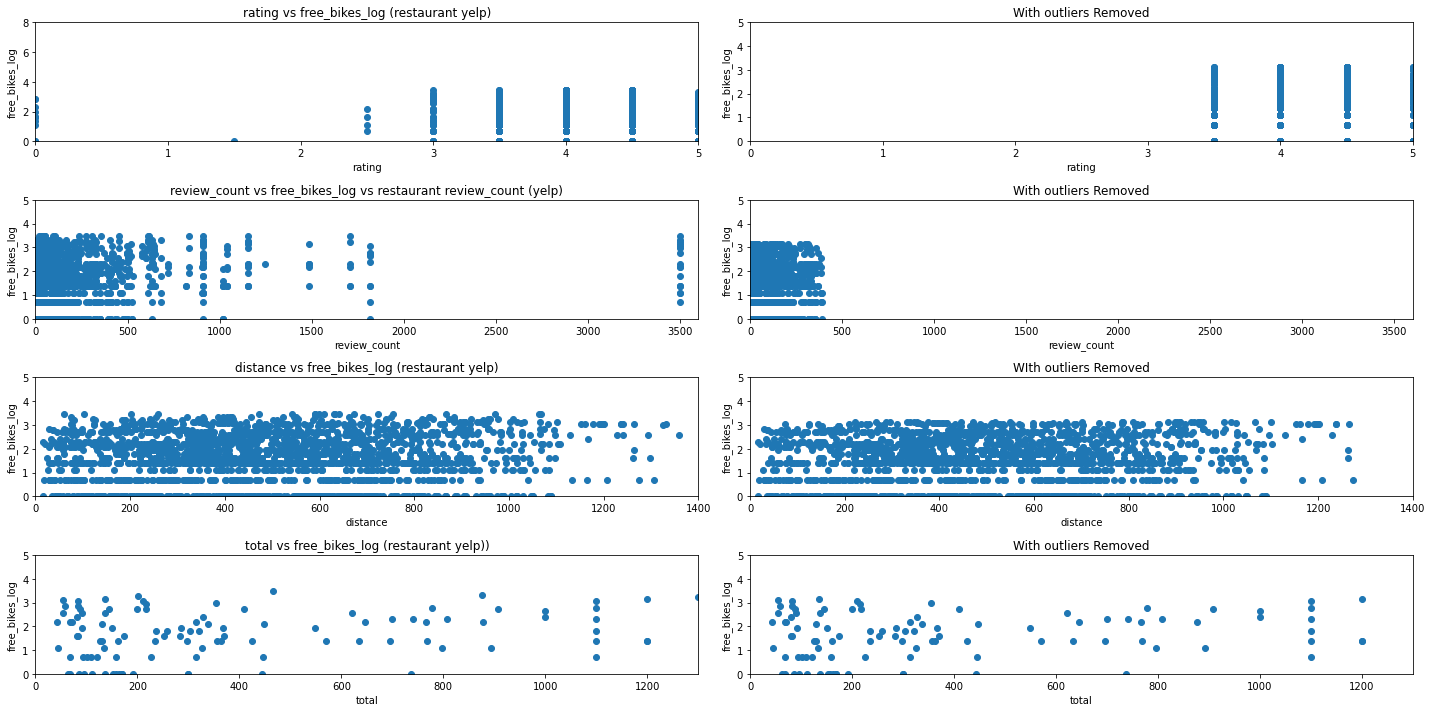

In [200]:
# Transforming the Y Data by log
bs_quant_log_df = bs_quant_df
bs_quant_log_clean_df = bs_quant_clean_df
bs_total_log_clean_df = bs_total_clean_df
bs_total_log_df = bs_total_df

# Clean data for log transformation
bs_quant_log_df = bs_quant_log_df[bs_quant_log_df['free_bikes'] > 0]
bs_quant_log_clean_df = bs_quant_log_clean_df[bs_quant_log_clean_df['free_bikes'] > 0]
bs_total_log_df = bs_total_log_df[bs_total_log_df['free_bikes'] > 0]
bs_total_log_clean_df = bs_total_log_clean_df[bs_total_log_clean_df['free_bikes'] > 0]

# Transform the data
bs_quant_log_df['free_bikes_log'] = np.log(bs_quant_log_df['free_bikes'])
bs_quant_log_clean_df['free_bikes_log'] = np.log(bs_quant_log_clean_df['free_bikes'])
bs_total_log_df['free_bikes_log'] = np.log(bs_total_log_df['free_bikes'])
bs_total_log_clean_df['free_bikes_log']= np.log(bs_total_log_clean_df['free_bikes'])


# Plot the Transformation

# Set Plot Dimensions
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))

# Plot rating
axes[0][0].scatter(bs_quant_log_df['rating'], bs_quant_log_df['free_bikes_log'])
axes[0][0].set_xlabel('rating')
axes[0][0].set_ylabel('free_bikes_log')
axes[0][0].set_title('rating vs free_bikes_log (restaurant yelp)')
axes[0][0].set_xlim(0,5)
axes[0][0].set_ylim(0,8)

axes[0][1].scatter(bs_quant_log_clean_df['rating'], bs_quant_log_clean_df['free_bikes_log'])
axes[0][1].set_xlabel('rating')
axes[0][1].set_ylabel('free_bikes_log')
axes[0][1].set_title('With outliers Removed')
axes[0][1].set_xlim(0,5)
axes[0][1].set_ylim(0,5)


# Plot review_count
axes[1][0].scatter(bs_quant_log_df['review_count'], bs_quant_log_df['free_bikes_log'])
axes[1][0].set_xlabel('review_count')
axes[1][0].set_ylabel('free_bikes_log')
axes[1][0].set_title('review_count vs free_bikes_log vs restaurant review_count (yelp)')
axes[1][0].set_xlim(0,3600)
axes[1][0].set_ylim(0,5)

axes[1][1].scatter(bs_quant_log_clean_df['review_count'], bs_quant_log_clean_df['free_bikes_log'])
axes[1][1].set_xlabel('review_count')
axes[1][1].set_ylabel('free_bikes_log')
axes[1][1].set_title('With outliers Removed')
axes[1][1].set_xlim(0,3600)
axes[1][1].set_ylim(0,5)

# Plot distance
axes[2][0].scatter(bs_quant_log_df['distance'], bs_quant_log_df['free_bikes_log'])
axes[2][0].set_xlabel('distance')
axes[2][0].set_ylabel('free_bikes_log')
axes[2][0].set_title('distance vs free_bikes_log (restaurant yelp)')
axes[2][0].set_xlim(0,1400)
axes[2][0].set_ylim(0,5)

axes[2][1].scatter(bs_quant_log_clean_df['distance'], bs_quant_log_clean_df['free_bikes_log'])
axes[2][1].set_xlabel('distance')
axes[2][1].set_ylabel('free_bikes_log')
axes[2][1].set_title('WIth outliers Removed')
axes[2][1].set_xlim(0,1400)
axes[2][1].set_ylim(0,5)

# Plot total
axes[3][0].scatter(bs_total_log_df['total'], bs_total_log_df['free_bikes_log'])
axes[3][0].set_xlabel('total')
axes[3][0].set_ylabel('free_bikes_log')
axes[3][0].set_title('total vs free_bikes_log (restaurant yelp))')
axes[3][0].set_xlim(0,1300)
axes[3][0].set_ylim(0,5)

axes[3][1].scatter(bs_total_log_clean_df['total'], bs_total_log_clean_df['free_bikes_log'])
axes[3][1].set_xlabel('total')
axes[3][1].set_ylabel('free_bikes_log')
axes[3][1].set_title('With outliers Removed')
axes[3][1].set_xlim(0,1300)
axes[3][1].set_ylim(0,5)

# Scatterplots
plt.tight_layout()
plt.show()


Conclusively, no transformations on the X and Y axis yield a linear trend.  Therefore, the original data will be kept


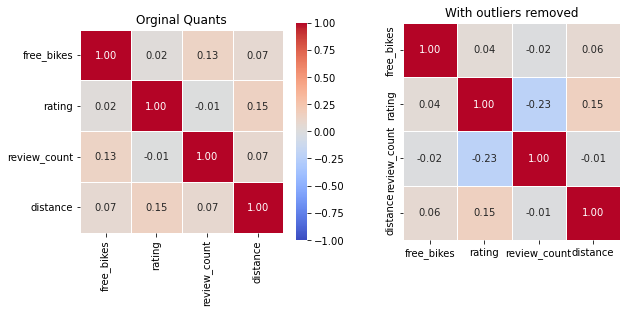

In [188]:
# The following data is not transformed

# Filter out repeated X value
bs_quant_df_temp = bs_quant_df.drop(columns='total')
bs_quant_clean_df_temp = bs_quant_clean_df.drop(columns='total')

# Set Plot Dimensions
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Heatmap of correlation
sns.heatmap(bs_quant_df_temp.corr(),
            vmin=-1.0,
            vmax=1.0,
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            linewidths=1,
            square=True,
            ax=axes[0]
)
axes[0].set_title('Orginal Quants')

# Heatmap of correlation with outliers removed
sns.heatmap(bs_quant_clean_df_temp.corr(),
            vmin=-1.0,
            vmax=1.0,
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            linewidths=1,
            square=True,
            cbar=False,
            ax=axes[1]
)
axes[1].set_title('With outliers removed')

# Plot the Heatmaps
plt.show()


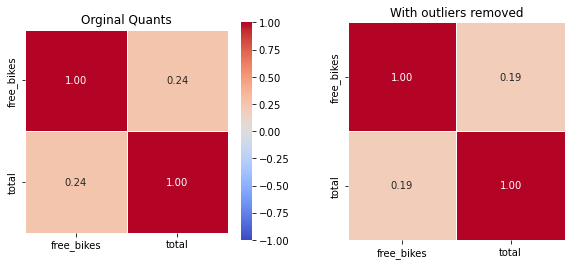

In [208]:
# The following data is not transformed

# Set Plot Dimensions
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Heatmap of correlation
sns.heatmap(bs_total_df.corr(),
            vmin=-1.0,
            vmax=1.0,
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            linewidths=1,
            square=True,
            ax=axes[0]
)
axes[0].set_title('Orginal Quants')

# Heatmap of correlation with outliers removed
sns.heatmap(bs_total_clean_df.corr(),
            vmin=-1.0,
            vmax=1.0,
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            linewidths=1,
            square=True,
            cbar=False,
            ax=axes[1]
)
axes[1].set_title('With outliers removed')

# Plot the Heatmaps
plt.show()

As expected regarding the scatterplots, there is no correlation between the variables.

In [228]:
# Export to csv
bs_quant_clean_df.to_csv(r'C:\Users\akans\Documents\Kierans_Documents\LHL\Statistical-Modelling-Project\data\results_yelp_clean.csv')

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [226]:
# Input tables into SQL database
conn = sqlite3.connect(r'C:\Users\akans\Documents\Kierans_Documents\LHL\Statistical-Modelling-Project\data\stats_model.db')
bs_quant_clean_df.to_sql('results_yelp_clean', conn, if_exists='replace', index=False)
cursor = conn.cursor()

Look at the data before and after the join to validate your data.

In [227]:
def validate (table_name, table_name_sql):
    query = f"SELECT * FROM '{table_name_sql}'"
    df_from_sql = pd.read_sql_query(query, conn)

    if table_name.equals(df_from_sql):
        print(f"{table_name} and the sql {df_from_sql} are exactly the same")
    else:
        print(f"{table_name} and the sql {df_from_sql} are not the same")

print(validate(bs_quant_clean_df,"results_yelp_clean"))


      free_bikes  rating  review_count    distance  total
0             13     4.5            16  172.375134     91
1             13     4.0            75  408.715724     91
2             13     4.5            95  794.661955     91
3             13     4.5             2  365.115394     91
4             13     4.5             4  777.980669     91
...          ...     ...           ...         ...    ...
2366          15     5.0             3  792.965307    199
2368          15     4.5           292  362.882616    199
2369          15     4.5            28  981.447702    199
2370          15     4.0            45  719.515102    199
2371          15     4.0             9  119.691706    199

[1983 rows x 5 columns] and the sql       free_bikes  rating  review_count    distance  total
0             13     4.5            16  172.375134     91
1             13     4.0            75  408.715724     91
2             13     4.5            95  794.661955     91
3             13     4.5           

In [224]:
# Close the connection
conn.close()